# ResidualAttention92 Model using CIFAR10 
# with 10% Noise

In [1]:
import numpy as np
import time
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, Activation, Add, MaxPooling2D, UpSampling2D, Multiply, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, TensorBoard
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.regularizers import l2
from utils.preprocess import CIFAR_preprocess, add_noise
from utils.AttentionResNet_CIFAR import AttentionResNet92
from utils.residual_unit_CIFAR import residual_unit
from utils.attention_block import attention_stage_1, attention_stage_2, attention_stage_3
%load_ext autoreload
%autoreload 2
%matplotlib inline


## Load CIFAR-10 Data

In [2]:
## dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

train_num = int(len(x_train) * 0.8)
x_val = x_train[train_num:, :, :, :]
y_val = y_train[train_num:]
#y_val = y_val.reshape(-1)
x_train = x_train[:train_num, :, :, :]
y_train = y_train[:train_num]
#y_train = y_train.reshape(-1)

#y_test = y_test.reshape(-1)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_validation shape:', x_val.shape)
print('y_validation shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_validation shape: (10000, 32, 32, 3)
y_validation shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [3]:
# calculate mean for each channel
mean = np.array(np.mean(x_train, axis=(0, 1, 2))).reshape([1,1,1,3])
x_train = x_train-mean
x_val = x_val - mean
x_test = x_test - mean

## Data Augmentation

In [4]:
# Noisy Label Robustness
x_train, y_train = add_noise(x_train, y_train, NOISE_LEVEL = 0.1)

## expand the original image to 40x40, and use random crop 32x32
def processing(image):
    pic = np.zeros(shape = (40, 40, 3))
    for c in range(image.shape[2]):
        a = image[:, :, c]
        a = np.pad(a, (4, 4))
        pic[:, :, c] = a
    pic = tf.image.random_crop(pic, [32, 32, 3], seed = 0)
    return pic

In [5]:
y_train = y_train.reshape(-1)
y_val = y_val.reshape(-1)
y_test = y_test.reshape(-1)

In [6]:
train_datagen = ImageDataGenerator(
            horizontal_flip=True,
            preprocessing_function=processing,
            validation_split=0.2)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_datagen.fit(x_train)
val_datagen.fit(x_val)
test_datagen.fit(x_test)

batch_size = 64
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)
test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

## Build up Residual Attention-92 Network

In [7]:
img_input = Input(shape=(32, 32, 3))
output = AttentionResNet92(img_input)
model = Model(img_input, output)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Train the Model

In [9]:
## build a learning rate call back
def lr_schedule(epoch):
    lr = 0.1
    if epoch > 100:
        lr *= 1e-1
    elif epoch > 150:
        lr *= 1e-2
        
    print('Learning rate:', lr)
    return lr
lr_callback = LearningRateScheduler(lr_schedule)

In [10]:
## use nesterov SGD as mentioned in the paper
model.compile(optimizer = tf.keras.optimizers.SGD(lr_schedule(0), momentum=0.9, nesterov=True, name='SGD'),
             loss='sparse_categorical_crossentropy',
             metrics = 'accuracy')

Learning rate: 0.1


In [11]:
## build an early stopping call back
early_stopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [12]:
start = time.time()
history = model.fit(train_generator, validation_data=val_generator, epochs = 180, callbacks=[lr_callback, early_stopper]) # 256
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Learning rate: 0.1
Epoch 1/180
625/625 [==============================] - 141s 225ms/step - loss: 1.8540 - accuracy: 0.3408 - val_loss: 1.5562 - val_accuracy: 0.4387 - lr: 0.1000
Learning rate: 0.1
Epoch 2/180
625/625 [==============================] - 134s 215ms/step - loss: 1.5927 - accuracy: 0.4650 - val_loss: 1.4235 - val_accuracy: 0.4911 - lr: 0.1000
Learning rate: 0.1
Epoch 3/180
625/625 [==============================] - 135s 217ms/step - loss: 1.4763 - accuracy: 0.5197 - val_loss: 1.2613 - val_accuracy: 0.5615 - lr: 0.1000
Learning rate: 0.1
Epoch 4/180
625/625 [==============================] - 136s 218ms/step - loss: 1.3977 - accuracy: 0.5548 - val_loss: 1.1722 - val_accuracy: 0.5924 - lr: 0.1000
Learning rate: 0.1
Epoch 5/180
625/625 [==============================] - 136s 218ms/step - loss: 1.3416 - accuracy: 0.5797 - val_loss: 1.1591 - val_accuracy: 0.6023 - lr: 0.1000
Learning rate: 0.1
Epoch 6/180
625/625 [==============================] - 133s 212ms/step - loss: 1.2978 

### Save the Model

In [13]:
## sava the weights
model.save_weights("./save_models/ResidualAttention92_Noise10_CIFAR10_weights.h5")

### Model Evaluation

In [14]:
# evaluation
val_scores = model.evaluate(val_generator, verbose=0)
test_scores = model.evaluate(test_generator, verbose=1)
print('validation loss:', val_scores[0])
print('validation accuracy:', val_scores[1])
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

157/157 [==============================] - 4s 27ms/step - loss: 0.6551 - accuracy: 0.7936
validation loss: 0.6506773233413696
validation accuracy: 0.7997000217437744
Test loss: 0.6551225781440735
Test accuracy: 0.7936000227928162


### Plot

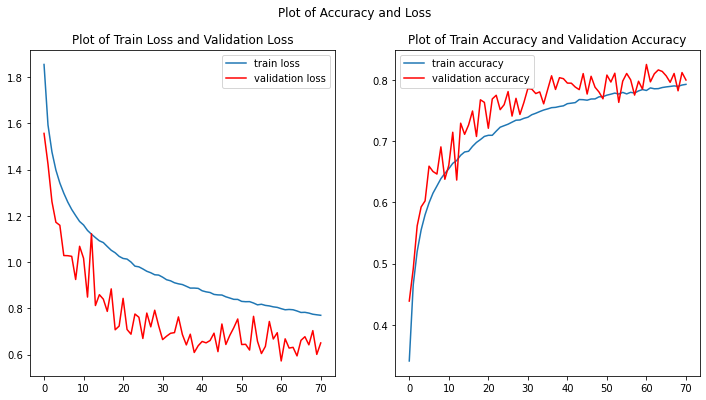

In [15]:
ni = range(len(history.history['loss']))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig.suptitle('Plot of Accuracy and Loss')
ax1.plot(ni,history.history['loss'],label='train loss')
ax1.plot(ni,history.history['val_loss'],label='validation loss',c='r')
ax1.set_title('Plot of Train Loss and Validation Loss')
ax1.legend()
ax2.plot(ni,history.history['accuracy'],label='train accuracy')
ax2.plot(ni,history.history['val_accuracy'],label='validation accuracy',c='r')
ax2.set_title('Plot of Train Accuracy and Validation Accuracy')
ax2.legend();